In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [5]:
filenames = os.listdir( "C:/Users/amanr/Downloads/train-20231106T130021Z-001/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0


In [7]:
df.tail()

,filename,category
397,dog.95.jpg,1
398,dog.96.jpg,1
399,dog.97.jpg,1
400,dog.98.jpg,1
401,dog.99.jpg,1


<Axes: >

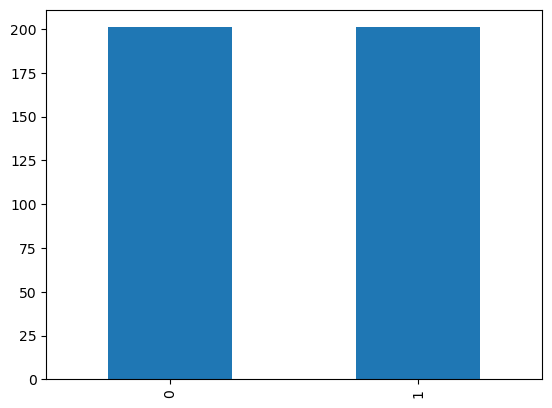

In [8]:
df['category'].value_counts().plot.bar()

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 61, 61, 64)       

In [12]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

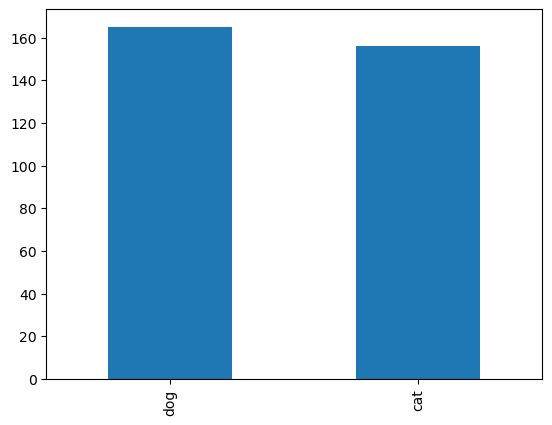

In [15]:
train_df['category'].value_counts().plot.bar()

<Axes: >

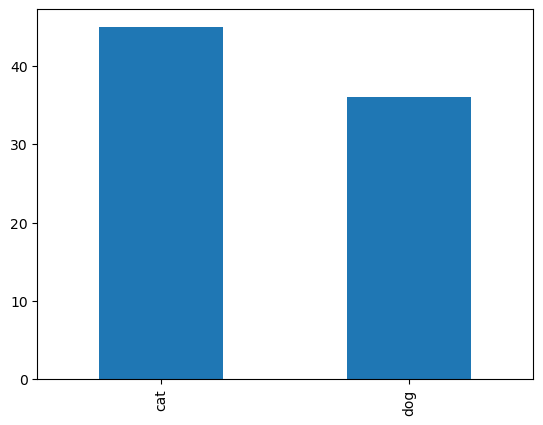

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df, "C:/Users/amanr/Downloads/train-20231106T130021Z-001/train/", x_col='filename',y_col='category',target_size=IMAGE_SIZE,class_mode='categorical',batch_size=batch_size)

Found 321 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
     "C:/Users/amanr/Downloads/train-20231106T130021Z-001/train/" , 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


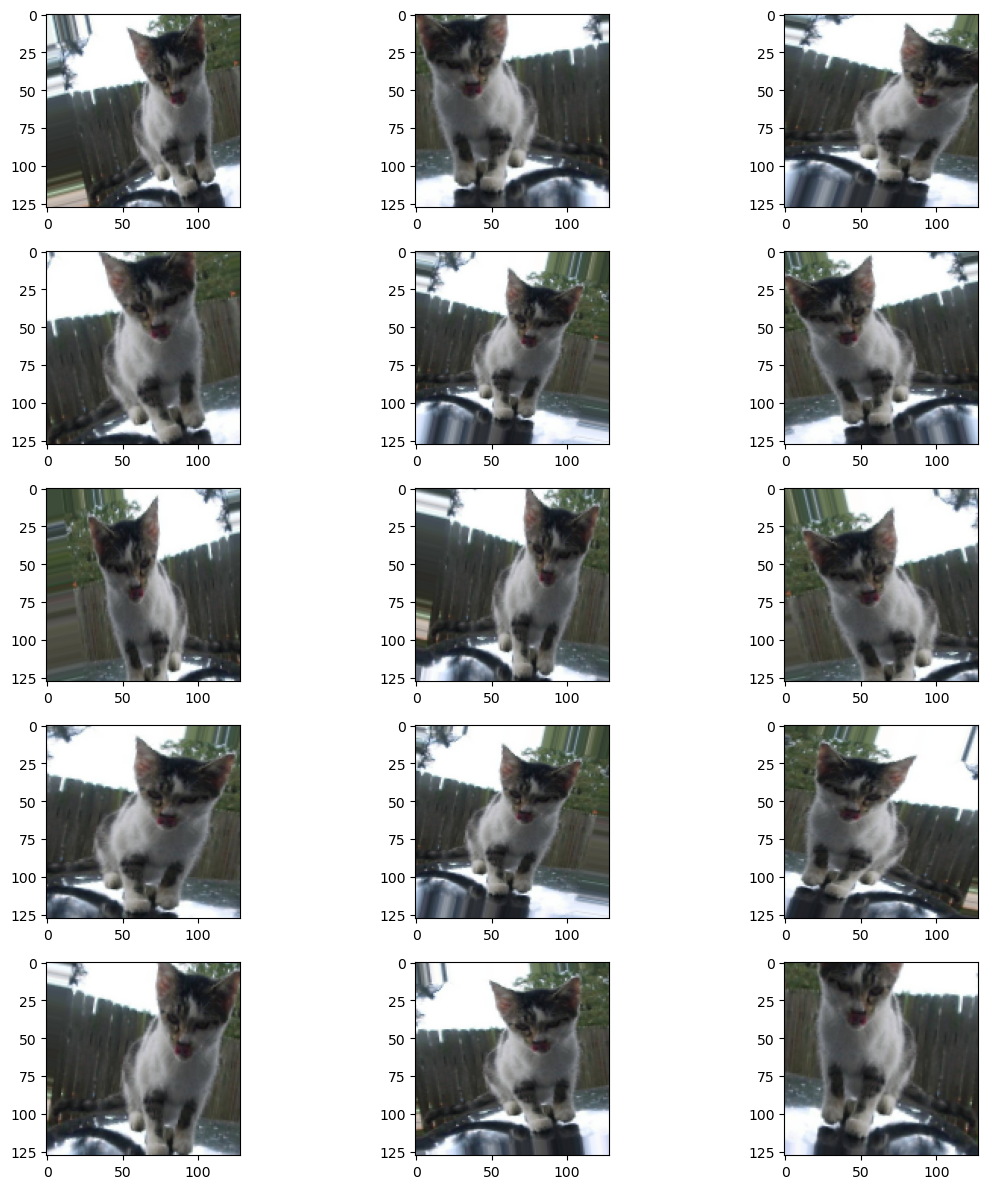

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)
model.save("model.h5")

Epoch 1/50
21/21 [==============================] - 32s 1s/step - loss: 1.6463 - accuracy: 0.5882 - val_loss: 1.8902 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 34s 2s/step - loss: 1.4546 - accuracy: 0.5261 - val_loss: 3.0210 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 33s 2s/step - loss: 1.1094 - accuracy: 0.6046 - val_loss: 1.8265 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.6536
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 32s 1s/step - loss: 0.9565 - accuracy: 0.6536 - val_loss: 0.8518 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 28s 1s/step - loss: 0.8056 - accuracy: 0.6144 - val_loss: 1.1232 - val_accuracy: 0.5467 - lr: 5.0000e-04
Epoch 6/50
21/21 [==============================] - ETA: 0s - loss: 0.90

C:\Users\amanr\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


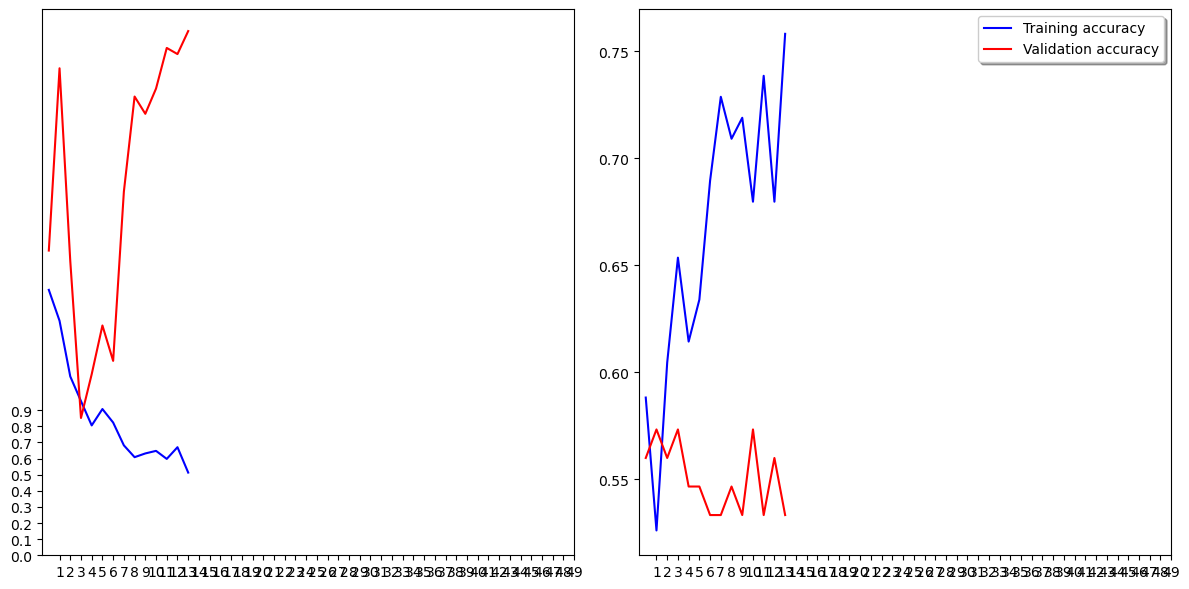

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [27]:
for i in range(10):
    all_test_images = os.listdir("C:/Users/amanr/Downloads/test-20231106T125953Z-001/test")
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'C:/Users/amanr/Downloads/test-20231106T125953Z-001/test{random_image}')
    img = cv2.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH))
    
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(['cat','dog'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 298ms/step
cat
1/1 [==============================] - 0s 57ms/step
cat
1/1 [==============================] - 0s 69ms/step
cat


KeyboardInterrupt: 